In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

import pandas as pd

# Reading the csv file
df = pd.read_csv('/content/drive/MyDrive/RansomwareData.csv')


Mounted at /content/drive/


In [ ]:
X = df.drop(df.columns[0], axis=1)
X = X.drop(df.columns[1], axis=1)
X = X.drop(df.columns[2], axis=1)
y = df[df.columns[2]]

y_binary = df[df.columns[1]]

# Create group labels
def convert_to_group(label):
    if 1 <= label <= 3:
        return 1
    elif 4 <= label <= 6:
        return 2
    elif 7 <= label <= 9:
        return 3
    elif 10 <= label <= 12:
        return 4
    else:
        return 0  # Assuming 0 is for goodware

y_group = y.apply(convert_to_group)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test, y_train_binary, y_test_binary, y_train_group, y_test_group = train_test_split(X, y, y_binary, y_group, test_size=0.2, random_state=42)

In [ ]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Define the autoencoder with a larger encoding dimension
input_dim = X_train.shape[1]
encoding_dim = 256  # Increased dimension

# Encoder
input_layer = Input(shape=(input_dim,))
encoder = Dense(encoding_dim, activation="relu")(input_layer)

# Decoder
decoder = Dense(input_dim, activation="sigmoid")(encoder)

# Autoencoder
autoencoder = Model(inputs=input_layer, outputs=decoder)

# Compile the autoencoder with a lower learning rate
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Train the autoencoder
autoencoder.fit(X_train, X_train, epochs=50, batch_size=4, validation_data=(X_test, X_test))


Epoch 1/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 66s 212ms/step - loss: 0.0470 - val_loss: 0.0027
Epoch 2/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 62s 204ms/step - loss: 0.0023 - val_loss: 0.0024
Epoch 3/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 61s 200ms/step - loss: 0.0021 - val_loss: 0.0023
Epoch 4/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 62s 202ms/step - loss: 0.0018 - val_loss: 0.0022
Epoch 5/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 55s 182ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 6/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 86s 194ms/step - loss: 0.0019 - val_loss: 0.0021
Epoch 7/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 8/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 64s 210ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 9/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 61s 200ms/step - loss: 0.0019 - val_loss: 0.0020
Epoch 10/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 83s 202ms/step - loss: 0.0018 - val_loss: 0.0020
Epoch 11/50
305/305 ━━━━━━━━━━━━━━━━━━━━ 82s 203ms/step - loss: 0.0017 - val_loss: 0.0020
Epoch 12/50
305/305

In [ ]:
# Extract the encoder part of the autoencoder
encoder_model = Model(inputs=input_layer, outputs=encoder)

# Transform the data to encoded representations
X_train_encoded = encoder_model.predict(X_train)
X_test_encoded = encoder_model.predict(X_test)


39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense, MultiHeadAttention, LayerNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Define the TransformerBlock class
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

# Input layer
input_layer = Input(shape=(encoding_dim, 1))

# Shared layers
x = Conv1D(filters=256, kernel_size=2, activation='relu')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = Conv1D(filters=128, kernel_size=2, activation='relu')(x)
x = MaxPooling1D(pool_size=2)(x)
x = TransformerBlock(embed_dim=128, num_heads=4, ff_dim=256)(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(100, activation='relu')(x)
x = Dense(64, activation='relu')(x)

# Binary Classification Head (Goodware vs Malicious)
binary_output = Dense(1, activation='sigmoid', name='binary_output')(x)

# Group Classification Head
group_output = Dense(4, activation='softmax', name='group_output')(x)

# Specific Classification Head
specific_output = Dense(12, activation='softmax', name='specific_output')(x)

# Create the model
model = Model(inputs=input_layer, outputs=[binary_output, group_output, specific_output])

# Compile the model
model.compile(optimizer='adam',
              loss={'binary_output': 'binary_crossentropy', 'group_output': 'categorical_crossentropy', 'specific_output': 'categorical_crossentropy'},
              metrics={'binary_output': 'accuracy', 'group_output': 'accuracy', 'specific_output': 'accuracy'})

# Summary of the model
model.summary()

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Mapping original labels to group labels
# Assuming original labels are in the range [0, 11]
label_to_group = {
    0: 0,  # Goodware
    1: 1,  # Critroni
    2: 1,  # CryptLocker
    3: 1,  # CryptoWall
    4: 2,  # KOLLAH
    5: 2,  # Kovter
    6: 2,  # Locker
    7: 3,  # MATSNU
    8: 3,  # PGPCODER
    9: 3,  # Reveton
    10: 3,  # TeslaCrypt
    11: 3,  # Trojan-Ransom
}

y_train_group = y_train.map(label_to_group)
y_test_group = y_test.map(label_to_group)

# One-hot encode the group and specific labels
y_train_group_categorical = to_categorical(y_train_group, num_classes=4)
y_train_categorical = to_categorical(y_train, num_classes=12)
y_test_group_categorical = to_categorical(y_test_group, num_classes=4)
y_test_categorical = to_categorical(y_test, num_classes=12)

# Train the model
history = model.fit(X_train_encoded,
                    {'binary_output': y_train_binary, 'group_output': y_train_group_categorical, 'specific_output': y_train_categorical},
                    epochs=500,
                    batch_size=4,
                    validation_data=(X_test_encoded, {'binary_output': y_test_binary, 'group_output': y_test_group_categorical, 'specific_output': y_test_categorical}),
                    callbacks=[early_stopping])


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_4 (Conv1D)         │ (None, 255, 256)       │            768 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_4           │ (None, 127, 256)       │              0 │ conv1d_4[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_5 (Conv1D)         │ (None, 126, 128)       │         65,664 │ max_pooling1d_4[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_5           │ (None, 63, 128)        │              0 │ conv1d_5[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_block_2       │ (None, 63, 128)        │        330,240 │ max_pooling1d_5[0][0]  │
│ (TransformerBlock)        │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 8064)           │              0 │ transformer_block_2[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_11 (Dense)          │ (None, 256)            │      2,064,640 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_12 (Dense)          │ (None, 100)            │         25,700 │ dense_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_13 (Dense)          │ (None, 64)             │          6,464 │ dense_12[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ binary_output (Dense)     │ (None, 1)              │             65 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ group_output (Dense)      │ (None, 4)              │            260 │ dense_13[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ specific_output (Dense)   │ (None, 12)             │            780 │ dense_13[0][0]         │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,494,581 (9.52 MB)

 Trainable params: 2,494,581 (9.52 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 33s 84ms/step - binary_output_accuracy: 0.6017 - group_output_accuracy: 0.5686 - loss: 3.9515 - specific_output_accuracy: 0.5425 - val_binary_output_accuracy: 0.9016 - val_group_output_accuracy: 0.6951 - val_loss: 2.0095 - val_specific_output_accuracy: 0.6984
Epoch 2/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 38s 75ms/step - binary_output_accuracy: 0.8718 - group_output_accuracy: 0.6622 - loss: 2.1981 - specific_output_accuracy: 0.6620 - val_binary_output_accuracy: 0.9246 - val_group_output_accuracy: 0.7082 - val_loss: 1.8883 - val_specific_output_accuracy: 0.6459
Epoch 3/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 41s 76ms/step - binary_output_accuracy: 0.9123 - group_output_accuracy: 0.7539 - loss: 1.7099 - specific_output_accuracy: 0.7214 - val_binary_output_accuracy: 0.9344 - val_group_output_accuracy: 0.7770 - val_loss: 1.5536 - val_specific_output_accuracy: 0.7639
Epoch 4/500
305/305 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - binary_output_accuracy: 0.9201 - group_o

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# Generate predictions
predictions = model.predict(X_test_encoded)

# Binary predictions and metrics
binary_predictions = (predictions[0] > 0.5).astype(int)  # Convert probabilities to 0 or 1
binary_accuracy = accuracy_score(y_test_binary, binary_predictions)
binary_precision = precision_score(y_test_binary, binary_predictions)
binary_recall = recall_score(y_test_binary, binary_predictions)
binary_f1 = f1_score(y_test_binary, binary_predictions)
# Specific predictions and metrics
specific_predictions = np.argmax(predictions[2], axis=1)
specific_accuracy = accuracy_score(y_test, specific_predictions)
specific_precision = precision_score(y_test, specific_predictions, average='macro')
specific_recall = recall_score(y_test, specific_predictions, average='macro')
specific_f1 = f1_score(y_test, specific_predictions, average='macro')

# Print the results
print(f"Binary Classification Metrics:\n"
      f"Accuracy: {binary_accuracy:.4f}\n"
      f"Precision: {binary_precision:.4f}\n"
      f"Recall: {binary_recall:.4f}\n"
      f"F1 Score: {binary_f1:.4f}")

print(f"\nSpecific Classification Metrics:\n"
      f"Accuracy: {specific_accuracy:.4f}\n"
      f"Precision: {specific_precision:.4f}\n"
      f"Recall: {specific_recall:.4f}\n"
      f"F1 Score: {specific_f1:.4f}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step
Binary Classification Metrics:
Accuracy: 0.9672
Precision: 0.9496
Recall: 0.9658
F1 Score: 0.9576

Specific Classification Metrics:
Accuracy: 0.8295
Precision: 0.4676
Recall: 0.4797
F1 Score: 0.4654


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


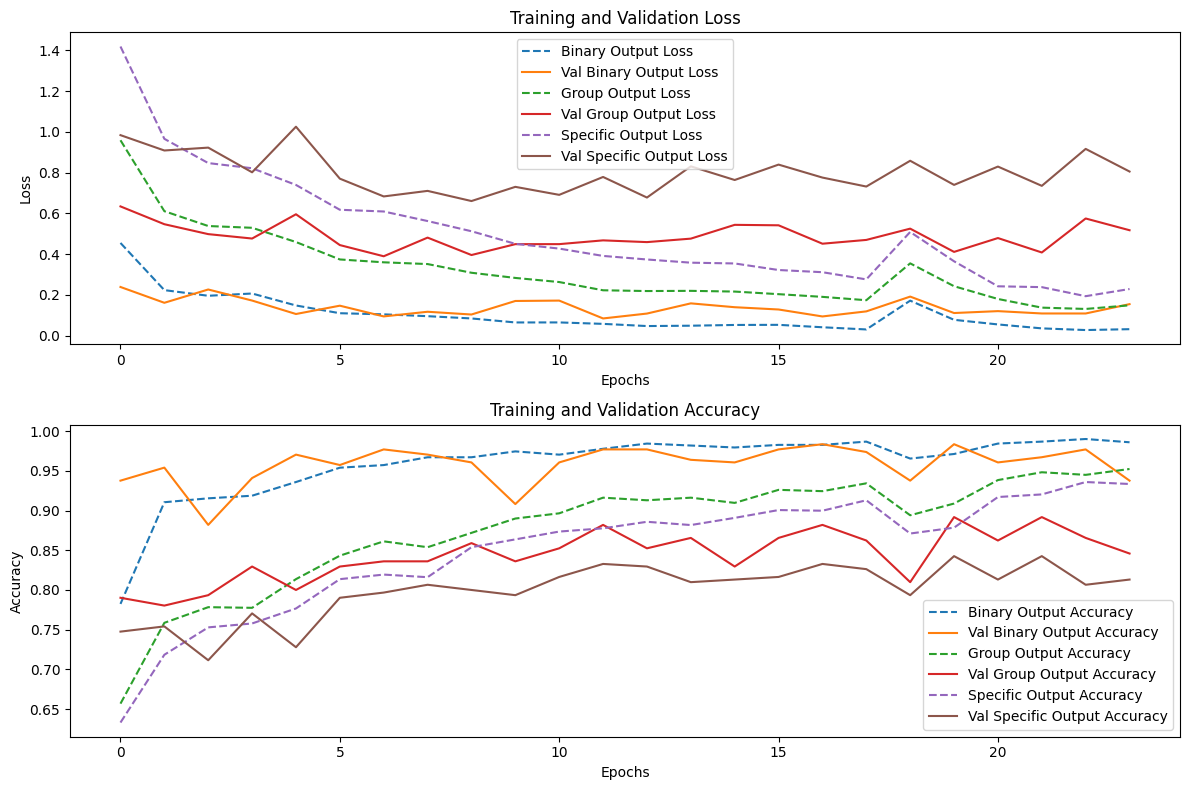

In [ ]:
import matplotlib.pyplot as plt

# Extract the history for each output
binary_loss = history.history['binary_output_loss']
val_binary_loss = history.history['val_binary_output_loss']
group_loss = history.history['group_output_loss']
val_group_loss = history.history['val_group_output_loss']
specific_loss = history.history['specific_output_loss']
val_specific_loss = history.history['val_specific_output_loss']

binary_acc = history.history['binary_output_accuracy']
val_binary_acc = history.history['val_binary_output_accuracy']
group_acc = history.history['group_output_accuracy']
val_group_acc = history.history['val_group_output_accuracy']
specific_acc = history.history['specific_output_accuracy']
val_specific_acc = history.history['val_specific_output_accuracy']

# Plot loss
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)
plt.plot(binary_loss, linestyle='--', label='Binary Output Loss')
plt.plot(val_binary_loss, label='Val Binary Output Loss')
plt.plot(group_loss, linestyle='--', label='Group Output Loss')
plt.plot(val_group_loss, label='Val Group Output Loss')
plt.plot(specific_loss, linestyle='--', label='Specific Output Loss')
plt.plot(val_specific_loss, label='Val Specific Output Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(2, 1, 2)
plt.plot(binary_acc, linestyle='--', label='Binary Output Accuracy')
plt.plot(val_binary_acc, label='Val Binary Output Accuracy')
plt.plot(group_acc, linestyle='--', label='Group Output Accuracy')
plt.plot(val_group_acc, label='Val Group Output Accuracy')
plt.plot(specific_acc, linestyle='--', label='Specific Output Accuracy')
plt.plot(val_specific_acc, label='Val Specific Output Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


10/10 [==============================] - 1s 71ms/step


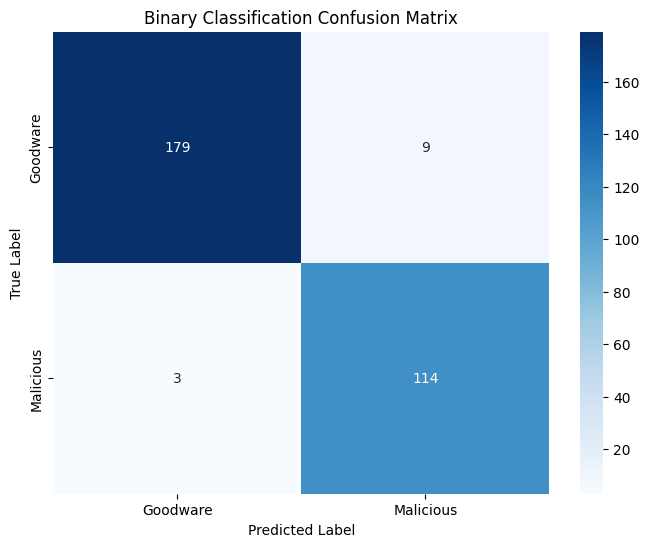

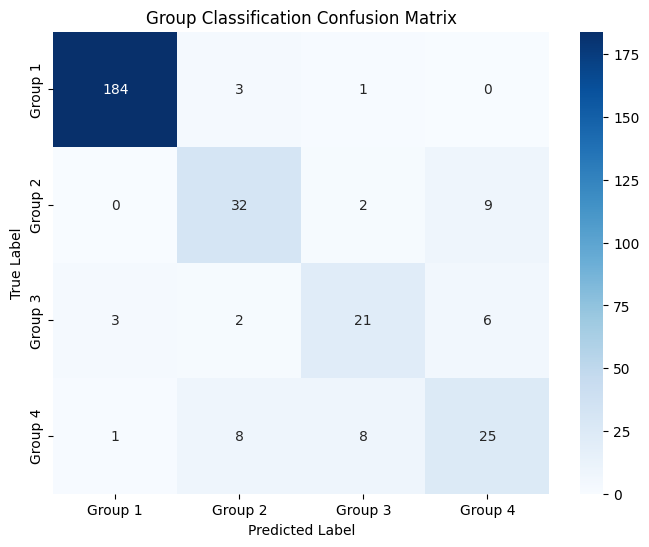

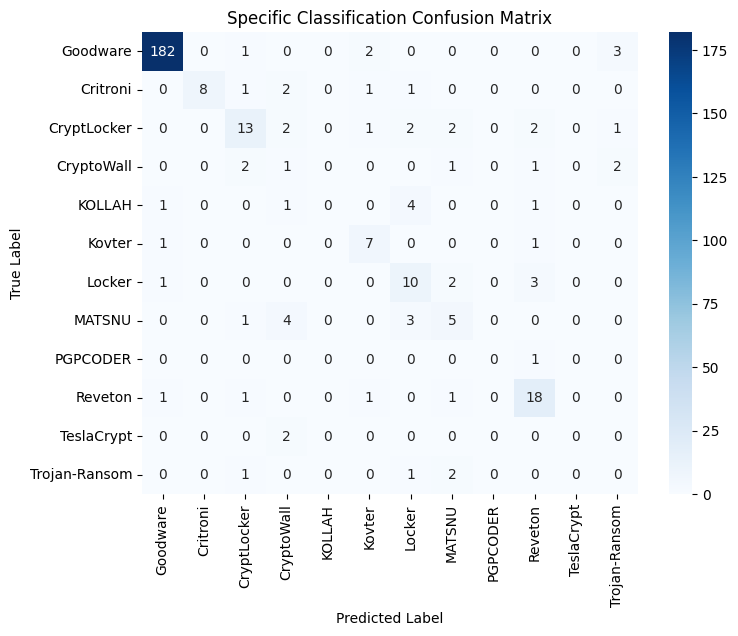

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Predict on the test set
predictions = model.predict(X_test_encoded)

# Binary classification confusion matrix
binary_preds = np.round(predictions[0]).astype(int)
binary_cm = confusion_matrix(y_test_binary, binary_preds)

# Group classification confusion matrix
group_preds = np.argmax(predictions[1], axis=1)
group_cm = confusion_matrix(y_test_group, group_preds)

# Specific classification confusion matrix
specific_preds = np.argmax(predictions[2], axis=1)
specific_cm = confusion_matrix(y_test, specific_preds)

# Plot confusion matrices
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Plot Binary classification confusion matrix
plot_confusion_matrix(binary_cm, classes=['Goodware', 'Malicious'], title='Binary Classification Confusion Matrix')

# Plot Group classification confusion matrix
group_labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4']
plot_confusion_matrix(group_cm, classes=group_labels, title='Group Classification Confusion Matrix')

# Plot Specific classification confusion matrix
specific_labels = ['Goodware', 'Critroni', 'CryptLocker', 'CryptoWall', 'KOLLAH', 'Kovter', 'Locker', 'MATSNU', 'PGPCODER', 'Reveton', 'TeslaCrypt', 'Trojan-Ransom']
plot_confusion_matrix(specific_cm, classes=specific_labels, title='Specific Classification Confusion Matrix')
